In [134]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [135]:
#reading the data
train = pd.read_csv('titanic_train.csv')
test=pd.read_csv('titanic_test.csv')

In [136]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


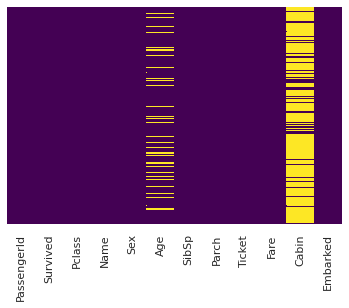

In [137]:
#missing data check in the training set
train.info()
sns.heatmap(train.isnull(),yticklabels = False,cbar=False,cmap='viridis');
#some data points in Age and Embarked categories missing, plenty missing in Cabin

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


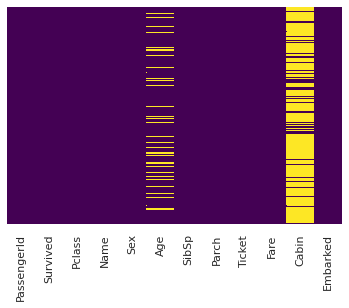

In [138]:
#missing data check in the test set
test.info()
sns.heatmap(train.isnull(),yticklabels = False,cbar=False,cmap='viridis');

Exploratory Data Analysis

Survival rate is 38.38%.


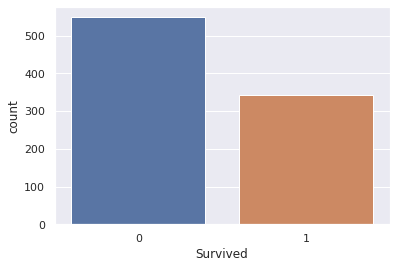

In [139]:
#Survivors distribution
sns.countplot(x='Survived', data=train);
print('Survival rate is ' + "%.2f%%" % (train[train['Survived']==1]['Survived'].count()/train['Survived'].count()*100)+'.')

,Sex,Survived
0,female,0.742038
1,male,0.188908


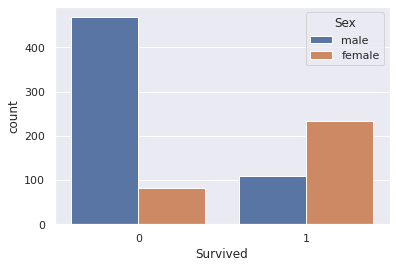

In [140]:
#Survivors by sex distribution
sns.countplot(x='Survived', hue='Sex', data=train);
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
#Survivors are predominantly women.

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


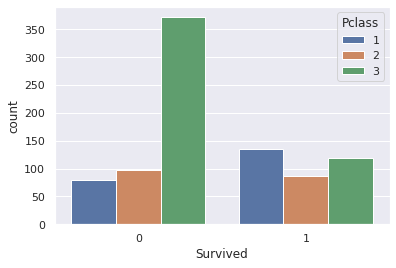

In [141]:
#Survivors by passanger class distribution
sns.countplot(x='Survived', hue='Pclass', data=train);
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
#While survivors are somewhat evenly distrubuted between the passenger classes, in the non-survivors group passengers
#from the 3rd class take the lead

/home/dataguy/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


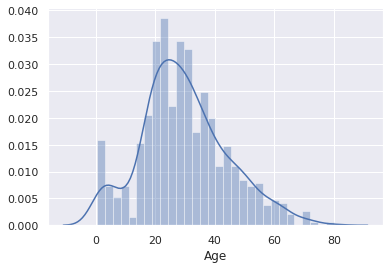

In [142]:
#Age distribution
sns.distplot(train['Age'].dropna(),bins=30);
#a bimodal distribution is observed - one mode in the children group, the other - in the adults one.

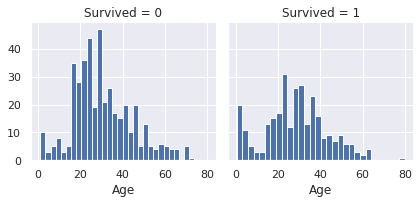

In [143]:
#Age distribution by survival
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=30);
#Children have high rate of survival

/home/dataguy/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,Age
Survived,
0,30.626179
1,28.343690


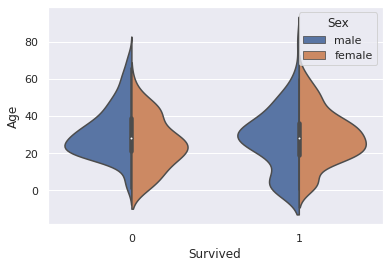

In [144]:
sns.violinplot(x='Survived', y='Age', data=train, hue='Sex', split=True);
train[['Age','Survived']].groupby(['Survived']).mean().sort_values(by='Age', ascending=False)
#The survivors and non-survivors on average have the same age
#Among children, boys tend to belong to the survivors group, while girls end up mostly in the non-survivors group
#Older men (65+) tend to not survive

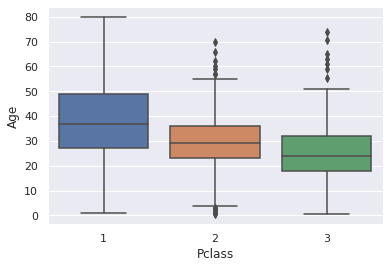

In [145]:
#Age distribution by passenger class
sns.boxplot(x='Pclass',y='Age',data=train)
#Passengers tend the be older with higher passenger class

/home/dataguy/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/dataguy/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,Fare
Survived,
1,26.0
0,10.5


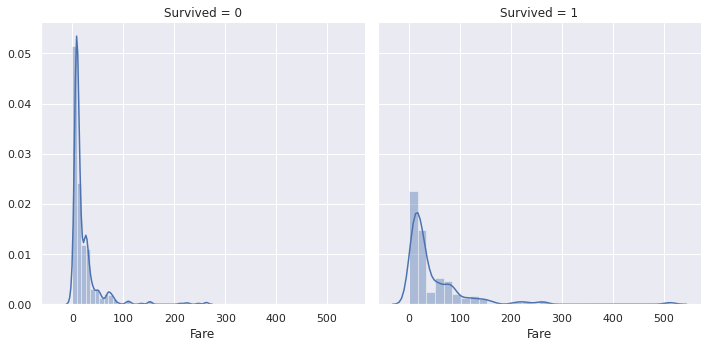

In [146]:
#Fare distribution
g = sns.FacetGrid(data=train, col = 'Survived', height=5)
g.map(sns.distplot, 'Fare', bins=30);
train[['Fare','Survived']].groupby(['Survived']).median().sort_values(by='Fare', ascending=False)
#Passengers who paid a higher fare for their ticket tend to be in the survivors group

In [147]:
#Median fare in each passenger class
for pclass in range(1,4):
    print('The median fare for '+ str(pclass) + '. class is ' + str(round(np.median(train[train['Pclass']==pclass]['Fare']),2)) + '.')

The median fare for 1. class is 60.29.
The median fare for 2. class is 14.25.
The median fare for 3. class is 8.05.


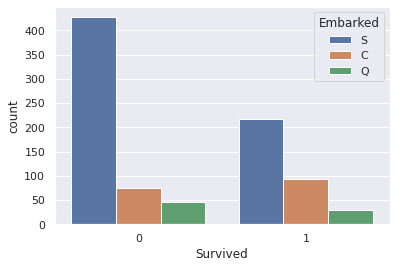

In [148]:
#Survivors by port of embarkment distribution
sns.countplot(x='Survived', hue='Embarked', data=train);
#Most passengers who embarked in Cherbourg,France(C) survived, while the opposite is true for the British ports

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


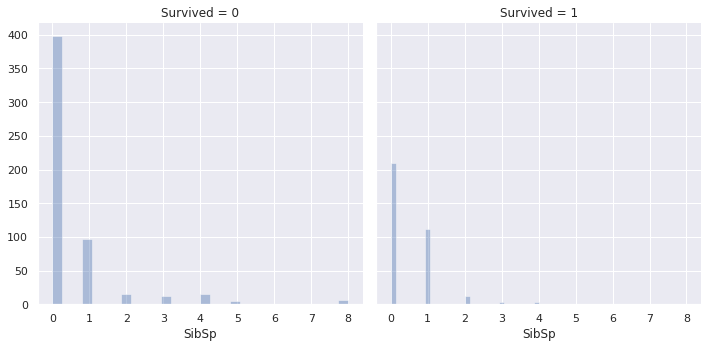

In [149]:
#SibSp distribution
g = sns.FacetGrid(data=train, col = 'Survived', height=5)
g.map(sns.distplot, 'SibSp', bins=30, kde=False);
train[['SibSp','Survived']].groupby(['SibSp']).mean().sort_values(by='Survived', ascending=False)
#Having only 1 or 2 siblings/spouse increased the likelihood of survival

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


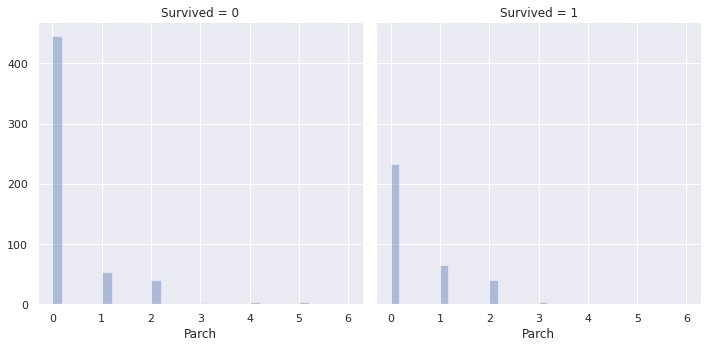

In [150]:
#Parch distribution
g = sns.FacetGrid(data=train, col = 'Survived', height=5)
g.map(sns.distplot, 'Parch', bins=30, kde=False);
train[['Parch','Survived']].groupby(['Parch']).mean().sort_values(by='Survived', ascending=False)
#Having only 1 to 3 parents/children increased the likelihood of survival

At this point, I am dropping variables PassengerId (as it does not have any informative function about passengers), Ticket (as this information is difficult to interpret), and Cabin (as most data are missing).
I will use Name variable to extract the titles of the passangers, as potentially it might be a useful feature to the model.

In [151]:
train.drop(['PassengerId','Ticket','Cabin'], axis=1, inplace=True)

I am leaving the other features in the model, either on the original form of with some modification. 

In [152]:
#Extracting the title out of the person's name
#function for extracting the title of a person
def title(col):
    title = col.split(sep=', ')[1].split(sep='. ')[0]
    return title
train['Title'] = train['Name'].apply(title)

In [153]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [154]:
train.groupby('Title').mean()[['Age']].sort_values(by='Age', ascending=False)
#The average age in each group is in line with common sense

,Age
Title,
Capt,70.000000
Col,58.000000
Sir,49.000000
Major,48.500000
Lady,48.000000
Rev,43.166667
Dr,42.000000
Don,40.000000
Jonkheer,38.000000


In [155]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)
#Some titles survived entirely (Mlle, Sir, Ms), some died entirely (Don, Rev, Jonkheer) 

,Title,Survived
16,the Countess,1.000000
9,Mlle,1.000000
15,Sir,1.000000
13,Ms,1.000000
5,Lady,1.000000
10,Mme,1.000000
12,Mrs,0.792000
8,Miss,0.697802
7,Master,0.575000
1,Col,0.500000


In [156]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).count().sort_values(by='Survived', ascending=False)
#Many titles appear only several times in the dataset

,Title,Survived
11,Mr,517
8,Miss,182
12,Mrs,125
7,Master,40
3,Dr,7
14,Rev,6
6,Major,2
1,Col,2
9,Mlle,2
15,Sir,1


In [157]:
#Placing rare titles under one category, and merging equivalent titles in one category
train['Title'] = train['Title'].replace(['Dr','Rev','Major','Col','Sir','Capt','Lady','Jonkheer','Don','the Countess'],'Rare')
train['Title'] = train['Title'].replace(['Mlle','Ms'],'Miss')
train['Title'] = train['Title'].replace('Mme','Mrs')

In [158]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)
#survival rate of the regrouped titles

,Title,Survived
3,Mrs,0.793651
1,Miss,0.702703
0,Master,0.575000
4,Rare,0.347826
2,Mr,0.156673


In [159]:
#dropping Name variable
train.drop('Name', axis=1, inplace=True)

In [160]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [161]:
#based on passenger class and title, I impute the mising values of Age
age_imp = train.groupby(['Pclass','Title']).mean()[['Age']].reset_index()
def impute_age(dpoint):
    Age = dpoint[0]
    Pclass = dpoint[1]
    Title = dpoint[2]
    if pd.isnull(Age):
        return age_imp[(age_imp['Pclass'] == dpoint[1])&(age_imp['Title'] == dpoint[2])]['Age'].values
    else:
        return Age

In [162]:
#Applying the above function
train['Age'] = train[['Age','Pclass','Title']].apply(impute_age,axis=1)

In [163]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22,1,0,7.2500,S,Mr
1,1,1,female,38,1,0,71.2833,C,Mrs
2,1,3,female,26,0,0,7.9250,S,Miss
3,1,1,female,35,1,0,53.1000,S,Mrs
4,0,3,male,35,0,0,8.0500,S,Mr


In [164]:
#train['AgeBand'] = pd.cut(train['Age'], 6)
#train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

In [165]:
#Mapping categorical variables
dict_sex = {'male':0,'female':1}
train['Sex']=train['Sex'].map(dict_sex)
            
dict_emb = {'S':0,'C':1,'Q':2}
train['Embarked']=train['Embarked'].map(dict_emb)
            
dict_titl = {'Mr':0,'Mrs':1,'Miss':2,'Master':3,'Rare':4}
train['Title']=train['Title'].map(dict_titl)

In [166]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,0.0,0
1,1,1,1,38,1,0,71.2833,1.0,1
2,1,3,1,26,0,0,7.9250,0.0,2
3,1,1,1,35,1,0,53.1000,0.0,1
4,0,3,0,35,0,0,8.0500,0.0,0


In [167]:
#dropping two rows with missing Embarked data
train.dropna(inplace=True,axis=0) 

In [168]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Sex         889 non-null int64
Age         889 non-null object
SibSp       889 non-null int64
Parch       889 non-null int64
Fare        889 non-null float64
Embarked    889 non-null float64
Title       889 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 69.5+ KB


Model and prediction

In [205]:
#defining the features and the target
X = train.drop('Survived', axis=1)
y = train['Survived']

In [170]:
#splitting the data into the train and test sets
from sklearn.model_selection import train_test_split

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [232]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(X_train,y_train)
pred = log.predict(X_test)
log_score = log.score(X_test,y_test)
log_score

/home/dataguy/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8576779026217228

In [221]:
#metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))
print('\n')
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       170
           1       0.82      0.78      0.80        97

    accuracy                           0.86       267
   macro avg       0.85      0.84      0.84       267
weighted avg       0.86      0.86      0.86       267



[[153  17]
 [ 21  76]]


In [204]:
#coefficient analysis
coef = pd.DataFrame(train.columns[1:],columns=['Feature'])
coef['Coefficient'] = pd.Series(log.coef_[0])
coef.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
1,Sex,2.339561
6,Embarked,0.313473
7,Title,0.304641
5,Fare,0.004969
2,Age,-0.026504
4,Parch,-0.178353
3,SibSp,-0.408770
0,Pclass,-0.937475


In [231]:
#Support Vector Machines
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
pred = svc.predict(X_test)
svc_score=svc.score(X_test,y_test)
svc_score

/home/dataguy/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7116104868913857

In [224]:
#metrics
print(classification_report(y_test, pred))
print('\n')
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       170
           1       0.62      0.53      0.57        97

    accuracy                           0.71       267
   macro avg       0.69      0.67      0.68       267
weighted avg       0.70      0.71      0.71       267



[[139  31]
 [ 46  51]]


In [230]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
knn_score=knn.score(X_test,y_test)
knn_score

0.7153558052434457

In [226]:
#metrics
print(classification_report(y_test, pred))
print('\n')
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       170
           1       0.61      0.60      0.60        97

    accuracy                           0.72       267
   macro avg       0.69      0.69      0.69       267
weighted avg       0.71      0.72      0.71       267



[[133  37]
 [ 39  58]]


In [229]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train,y_train)
pred = random_forest.predict(X_test)
rf_score=random_forest.score(X_test,y_test)
rf_score

0.846441947565543

In [228]:
#metrics
print(classification_report(y_test, pred))
print('\n')
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       170
           1       0.79      0.76      0.77        97

    accuracy                           0.84       267
   macro avg       0.83      0.82      0.82       267
weighted avg       0.84      0.84      0.84       267



[[150  20]
 [ 23  74]]


In [235]:
models = pd.DataFrame({'Model':['Logistic Regression','Support Vector Machines','KNN','Random Forests'],'Score':[log_score,svc_score,knn_score,rf_score]})
models.sort_values(by = 'Score', ascending = False)

,Model,Score
0,Logistic Regression,0.857678
3,Random Forests,0.846442
2,KNN,0.715356
1,Support Vector Machines,0.711610


In [236]:
#test set adaptation
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [237]:
test['Title'] = test['Name'].apply(title)

In [240]:
test['Title'] = test['Title'].replace(['Dr','Rev','Major','Col','Sir','Capt','Lady','Jonkheer','Don','Dona','the Countess'],'Rare')
test['Title'] = test['Title'].replace(['Mlle','Ms'],'Miss')
test['Title'] = test['Title'].replace('Mme','Mrs')

In [243]:
test.drop('Name', axis=1, inplace=True)

In [244]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Title          418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [245]:
test['Age'] = test[['Age','Pclass','Title']].apply(impute_age,axis=1)

In [246]:
test.drop(['Ticket','Cabin'], axis=1, inplace=True)

In [254]:
test['Fare'].fillna(value = test['Fare'].median(),inplace=True)

In [256]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            418 non-null object
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
Title          418 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 29.5+ KB


In [257]:
#Mapping categorical variables
test['Sex']=test['Sex'].map(dict_sex)
            
test['Embarked']=test['Embarked'].map(dict_emb)

test['Title']=test['Title'].map(dict_titl)

In [258]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,34.5,0,0,7.8292,2,0
1,893,3,1,47,1,0,7.0000,0,1
2,894,2,0,62,0,0,9.6875,2,0
3,895,3,0,27,0,0,8.6625,0,0
4,896,3,1,22,1,1,12.2875,0,1


In [259]:
X = test.drop('PassengerId', axis=1)

In [260]:
pred_test = log.predict(X)

In [261]:
submission = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':pred_test})

In [264]:
submission.to_csv('submission.csv', index=False)